In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
import openpyxl
import pandas as pd
from utils.hmatr import Hmatr

%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

rpy2.robjects.numpy2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

utils.install_packages('Rssa')

rssa = importr('Rssa')

Unable to determine R home: [WinError 2] Не удается найти указанный файл
Unable to determine R library path: Command '('D:\\Program Files\\R\\R-4.1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.
R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.1/Rssa_1.0.4.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2218703 bytes (2.1 MB)

R[write to console]: downloaded 2.1 MB




package 'Rssa' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ivank\AppData\Local\Temp\Rtmpk5bEfi\downloaded_packages


d:\education\magistracy\researchwork\researchwork\venv\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(
R[write to console]: Warning:
R[write to console]:  package 'Rssa' is in use and will not be installed



# Инициализация

In [2]:
N = 700
w1 = 1/10
w2 = 1/5
C1 = 1
C2 = 2
phi1 = 0
phi2 = np.pi/2
Q = 301  # 301 номер, значит разладка в ряде будет на 302й точке, если ряд задан с 0.
B = 100
T_ = 100
L = 50
r = 2
noise_sd = 0.5

method = "svd"

In [3]:
def plotSeries(s, title='Series', w=16, h=4):
    plt.figure(figsize=(w, h))
    plt.title(title)
    plt.plot(s)

## Данные

Генерируем данные с фиксированным шумом и без.

In [4]:
seriesPermanent = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w2*n + phi1)
seriesTemporary = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C2*np.sin(2*np.pi*w1*n + phi1)
seriesShifted = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w1*n + phi2)
seriesOutlier = lambda n: C1*np.sin(2*np.pi*w1*n + phi1)

np.random.seed(12345)
eps = np.random.normal(scale=noise_sd, size=N)

fPerm = [seriesPermanent(i) for i in range(N)]
fPermNoise = fPerm + eps
hmPerm = Hmatr(fPerm, B, T_, L, neig=r, svdMethod=method)
hmPermNoise = Hmatr(fPermNoise, B, T_, L, neig=r, svdMethod=method)

fTemp = [seriesTemporary(i) for i in range(N)]
tmp = deepcopy(eps)
tmp[:Q] = tmp[:Q]/2
fTempNoise = fTemp + tmp
hmTemp = Hmatr(fTemp, B, T_, L, neig=r, svdMethod=method)
hmTempNoise = Hmatr(fTempNoise, B, T_, L, neig=r, svdMethod=method)

fShifted = [seriesShifted(i) for i in range(N)]
fShiftedNoise = fShifted + eps
hmShifted = Hmatr(fShifted, B, T_, L, neig=r, svdMethod=method)
hmShiftedNoise = Hmatr(fShiftedNoise, B, T_, L, neig=r, svdMethod=method)


fOutlier = [seriesOutlier(i) for i in range(N)]
fOutlier[Q] = fOutlier[Q] + C1*10
fOutlierNoise = fOutlier + eps
hmOutlier = Hmatr(fOutlier, B, T_, L, neig=r, svdMethod=method)
hmOutlierNoise = Hmatr(fOutlierNoise, B, T_, L, neig=r, svdMethod=method)

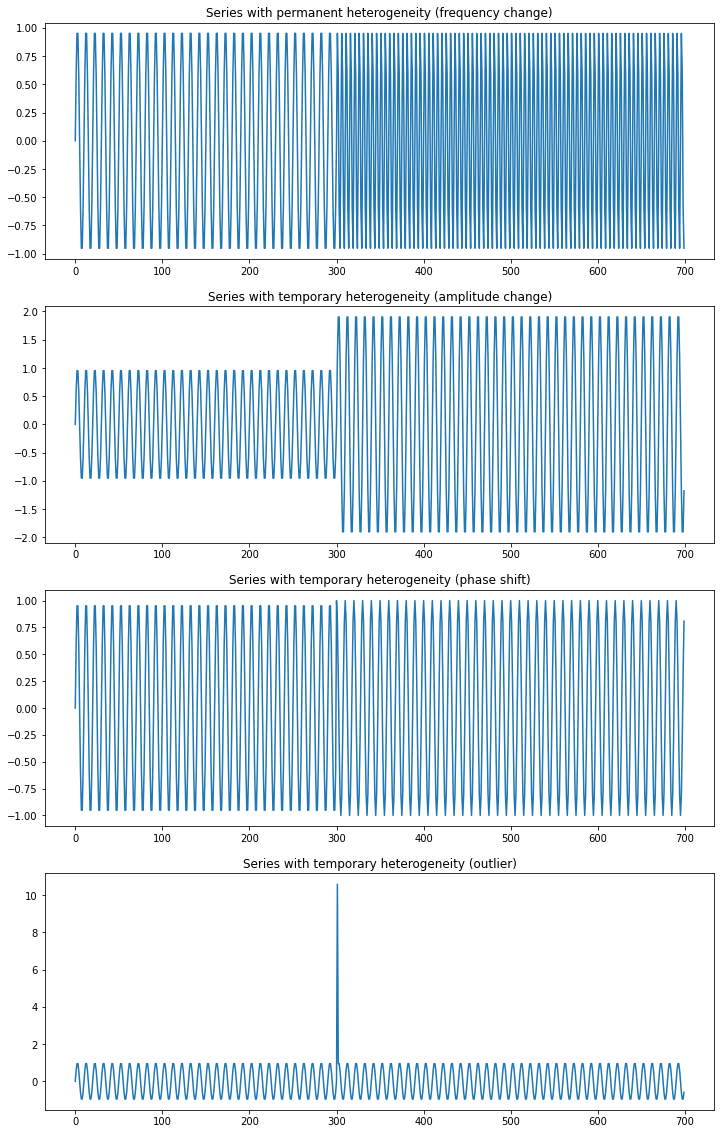

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12, 20))

ax1.plot(fPerm)
ax1.set_title('Series with permanent heterogeneity (frequency change)')

ax2.plot(fTemp)
ax2.set_title("Series with temporary heterogeneity (amplitude change)")

ax3.plot(fShifted)
ax3.set_title("Series with temporary heterogeneity (phase shift)")

ax4.plot(fOutlier)
ax4.set_title("Series with temporary heterogeneity (outlier)");
# plt.savefig('report/tex/images/seriesTests.png')

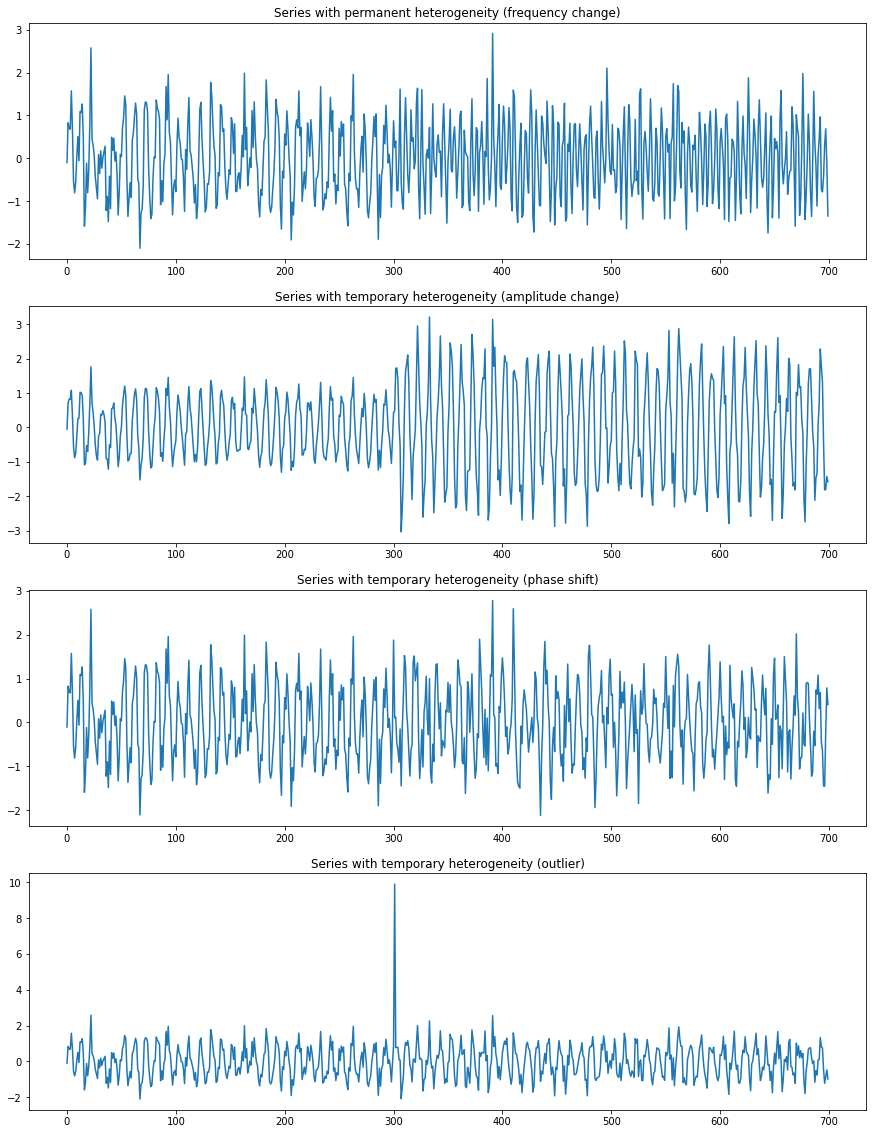

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15, 20))

ax1.plot(fPermNoise)
ax1.set_title('Series with permanent heterogeneity (frequency change)')

ax2.plot(fTempNoise)
ax2.set_title("Series with temporary heterogeneity (amplitude change)")

ax3.plot(fShiftedNoise)
ax3.set_title("Series with temporary heterogeneity (phase shift)")

ax4.plot(fOutlierNoise)
ax4.set_title("Series with temporary heterogeneity (outlier)");
# plt.savefig('report/tex/images/seriesNoisedTests.png')

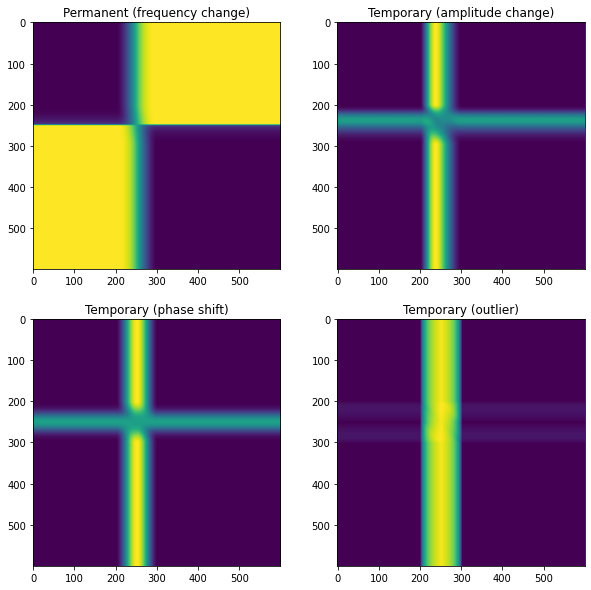

In [7]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(10, 10))

ax1[0].imshow(hmPerm.hmatr)
ax1[0].set_title("Permanent (frequency change)")

ax1[1].imshow(hmTemp.hmatr)
ax1[1].set_title("Temporary (amplitude change)")

ax2[0].imshow(hmShifted.hmatr)
ax2[0].set_title("Temporary (phase shift)")

ax2[1].imshow(hmOutlier.hmatr)
ax2[1].set_title("Temporary (outlier)");

Text(0.5, 1.0, 'Temporary (outlier)')

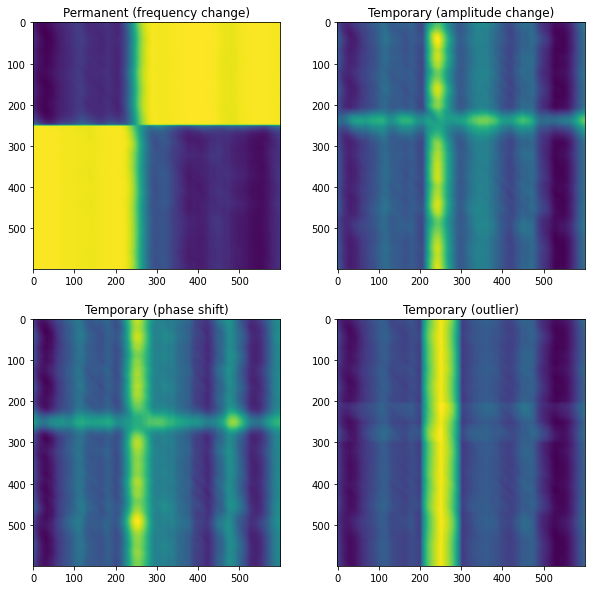

In [8]:
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(10, 10))

ax1[0].imshow(hmPermNoise.hmatr)
ax1[0].set_title("Permanent (frequency change)")

ax1[1].imshow(hmTempNoise.hmatr)
ax1[1].set_title("Temporary (amplitude change)")

ax2[0].imshow(hmShiftedNoise.hmatr)
ax2[0].set_title("Temporary (phase shift)")

ax2[1].imshow(hmOutlierNoise.hmatr)
ax2[1].set_title("Temporary (outlier)")

# plt.savefig("heterogeneity_types_noised.png")

Посмотрим на функции разладки

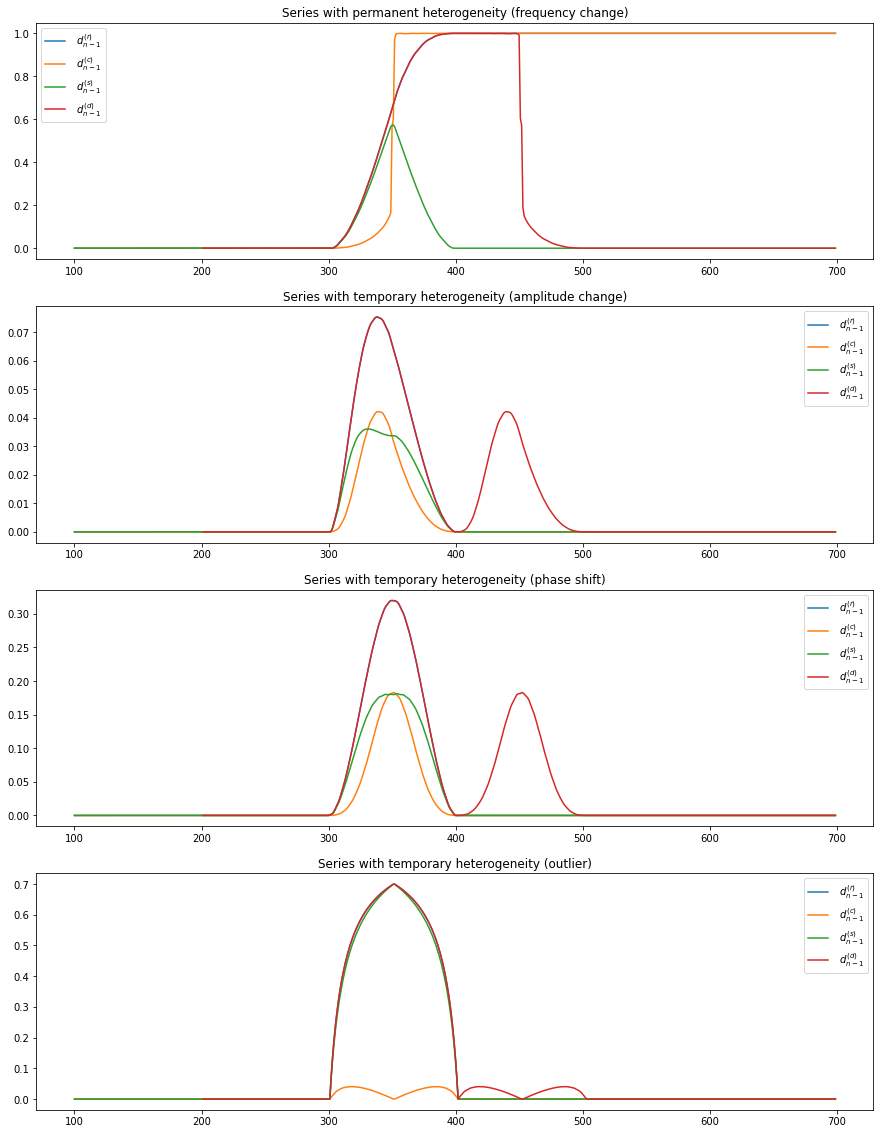

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15, 20))

ax1.set_title('Series with permanent heterogeneity (frequency change)')
ax1.plot(np.arange(hmPerm.T, hmPerm.N), hmPerm.getRow(0), label=r' $d_{n-1}^{(r)} $')
ax1.plot(np.arange(hmPerm.B, hmPerm.N), hmPerm.getCol(0), label=r' $d_{n-1}^{(c)} $')
ax1.plot(np.arange(hmPerm.T, hmPerm.N), hmPerm.getSym(), label=r' $d_{n-1}^{(s)} $')  # hmPerm.T - seems to be wrong.
ax1.plot(np.arange(hmPerm.B + hmPerm.T + 1, hmPerm.N), hmPerm.getDiag(), label=r' $d_{n-1}^{(d)} $')
ax1.legend()

ax2.set_title("Series with temporary heterogeneity (amplitude change)")
ax2.plot(np.arange(hmTemp.T, hmTemp.N), hmTemp.getRow(0), label=r' $d_{n-1}^{(r)} $')
ax2.plot(np.arange(hmTemp.B, hmTemp.N), hmTemp.getCol(0), label=r' $d_{n-1}^{(c)} $')
ax2.plot(np.arange(hmTemp.T, hmTemp.N), hmTemp.getSym(), label=r' $d_{n-1}^{(s)} $')  # hmTemp.T - seems to be wrong.
ax2.plot(np.arange(hmTemp.B + hmTemp.T + 1, hmTemp.N), hmTemp.getDiag(), label=r' $d_{n-1}^{(d)} $')
ax2.legend()

ax3.set_title("Series with temporary heterogeneity (phase shift)")
ax3.plot(np.arange(hmShifted.T, hmShifted.N), hmShifted.getRow(0), label=r' $d_{n-1}^{(r)} $')
ax3.plot(np.arange(hmShifted.B, hmShifted.N), hmShifted.getCol(0), label=r' $d_{n-1}^{(c)} $')
ax3.plot(np.arange(hmShifted.T, hmShifted.N), hmShifted.getSym(), label=r' $d_{n-1}^{(s)} $')  # hmShifted.T - seems to be wrong.
ax3.plot(np.arange(hmShifted.B + hmShifted.T + 1, hmShifted.N), hmShifted.getDiag(), label=r' $d_{n-1}^{(d)} $')
ax3.legend()

ax4.set_title("Series with temporary heterogeneity (outlier)");
ax4.plot(np.arange(hmOutlier.T, hmOutlier.N), hmOutlier.getRow(0), label=r' $d_{n-1}^{(r)} $')
ax4.plot(np.arange(hmOutlier.B, hmOutlier.N), hmOutlier.getCol(0), label=r' $d_{n-1}^{(c)} $')
ax4.plot(np.arange(hmOutlier.T, hmOutlier.N), hmOutlier.getSym(), label=r' $d_{n-1}^{(s)} $')  # hmOutlier.T - seems to be wrong.
ax4.plot(np.arange(hmOutlier.B + hmOutlier.T + 1, hmOutlier.N), hmOutlier.getDiag(), label=r' $d_{n-1}^{(d)} $')
ax4.legend()

# plt.savefig('report/tex/images/detectionTests.png')

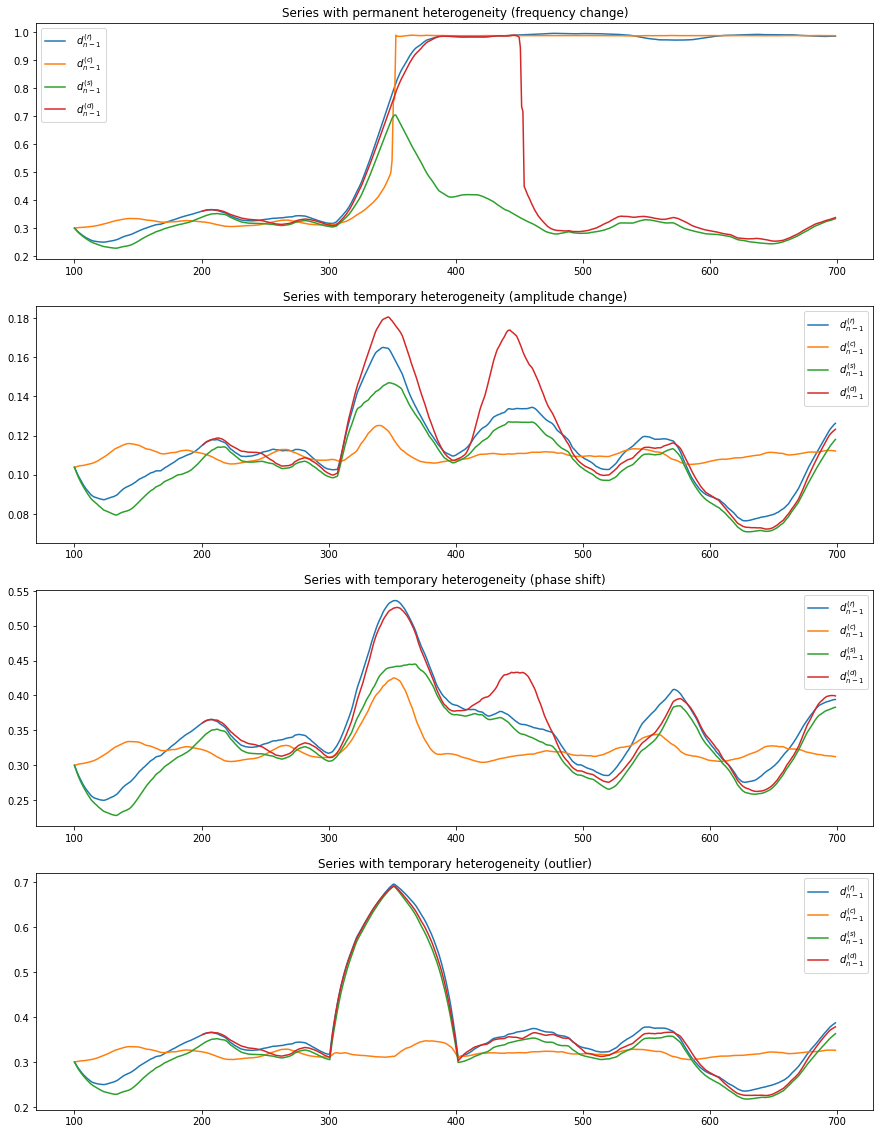

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15, 20))

ax1.set_title('Series with permanent heterogeneity (frequency change)')
ax1.plot(np.arange(hmPermNoise.T, hmPermNoise.N), hmPermNoise.getRow(0), label=r' $d_{n-1}^{(r)} $')
ax1.plot(np.arange(hmPermNoise.B, hmPermNoise.N), hmPermNoise.getCol(0), label=r' $d_{n-1}^{(c)} $')
ax1.plot(np.arange(hmPermNoise.T, hmPermNoise.N), hmPermNoise.getSym(), label=r' $d_{n-1}^{(s)} $')  # hmPermNoise.T - seems to be wrong.
ax1.plot(np.arange(hmPermNoise.B + hmPermNoise.T + 1, hmPermNoise.N), hmPermNoise.getDiag(), label=r' $d_{n-1}^{(d)} $')
ax1.legend()

ax2.set_title("Series with temporary heterogeneity (amplitude change)")
ax2.plot(np.arange(hmTempNoise.T, hmTempNoise.N), hmTempNoise.getRow(0), label=r' $d_{n-1}^{(r)} $')
ax2.plot(np.arange(hmTempNoise.B, hmTempNoise.N), hmTempNoise.getCol(0), label=r' $d_{n-1}^{(c)} $')
ax2.plot(np.arange(hmTempNoise.T, hmTempNoise.N), hmTempNoise.getSym(), label=r' $d_{n-1}^{(s)} $')  # hmTempNoise.T - seems to be wrong.
ax2.plot(np.arange(hmTempNoise.B + hmTempNoise.T + 1, hmTempNoise.N), hmTempNoise.getDiag(), label=r' $d_{n-1}^{(d)} $')
ax2.legend()

ax3.set_title("Series with temporary heterogeneity (phase shift)")
ax3.plot(np.arange(hmShiftedNoise.T, hmShiftedNoise.N), hmShiftedNoise.getRow(0), label=r' $d_{n-1}^{(r)} $')
ax3.plot(np.arange(hmShiftedNoise.B, hmShiftedNoise.N), hmShiftedNoise.getCol(0), label=r' $d_{n-1}^{(c)} $')
ax3.plot(np.arange(hmShiftedNoise.T, hmShiftedNoise.N), hmShiftedNoise.getSym(), label=r' $d_{n-1}^{(s)} $')  # hmShiftedNoise.T - seems to be wrong.
ax3.plot(np.arange(hmShiftedNoise.B + hmShiftedNoise.T + 1, hmShiftedNoise.N), hmShiftedNoise.getDiag(), label=r' $d_{n-1}^{(d)} $')
ax3.legend()

ax4.set_title("Series with temporary heterogeneity (outlier)");
ax4.plot(np.arange(hmOutlierNoise.T, hmOutlierNoise.N), hmOutlierNoise.getRow(0), label=r' $d_{n-1}^{(r)} $')
ax4.plot(np.arange(hmOutlierNoise.B, hmOutlierNoise.N), hmOutlierNoise.getCol(0), label=r' $d_{n-1}^{(c)} $')
ax4.plot(np.arange(hmOutlierNoise.T, hmOutlierNoise.N), hmOutlierNoise.getSym(), label=r' $d_{n-1}^{(s)} $')  # hmOutlierNoise.T - seems to be wrong.
ax4.plot(np.arange(hmOutlierNoise.B + hmOutlierNoise.T + 1, hmOutlierNoise.N), hmOutlierNoise.getDiag(), label=r' $d_{n-1}^{(d)} $')
ax4.legend()

# plt.savefig('report/tex/images/detectionNoisedTests.png')

# Моделирование

Смоделируем случайный шум с дисперсией `noiseVariance` `200` раз на отрезке $[0, \cdots, Q-1]$ и посчитаем характеристики:
* Средний максимум;
* Средний 95 процентиль.

In [15]:
?modellingNoiseStatistics

In [105]:
from utils.modelling import *

In [106]:
%%time
ds, summary_conf_ints = modellingNoiseStatistics(
    dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
    iterNum=200,
    N=N,
    B=B,
    T=T_,
    Q=Q,
    L=L,
    r=r,
    method=method,
    vareps = noise_sd
)

{'Permanent': c_intervals(Row=array([[0.13146149, 0.12933927],
       [0.13175752, 0.12963067]]), Col=array([[0.11243308, 0.11200153],
       [0.11277647, 0.11234506]]), Sym=array([[0.12884761, 0.12637775],
       [0.12913405, 0.12666032]]), Diag=array([[0.12395158, 0.122779  ],
       [0.12428702, 0.12311421]])), 'Temporary': c_intervals(Row=array([[0.03626809, 0.03571867],
       [0.0363577 , 0.03580827]]), Col=array([[0.03005967, 0.02992679],
       [0.03015614, 0.03002299]]), Sym=array([[0.03555488, 0.03494521],
       [0.03564293, 0.03503363]]), Diag=array([[0.03430151, 0.03392161],
       [0.0343871 , 0.03400678]])), 'Shifted': c_intervals(Row=array([[0.13056848, 0.12864185],
       [0.13086826, 0.12893882]]), Col=array([[0.11149592, 0.11105338],
       [0.11184159, 0.11139856]]), Sym=array([[0.12780515, 0.12563693],
       [0.12809742, 0.12592857]]), Diag=array([[0.12276918, 0.12132264],
       [0.12308127, 0.12163566]])), 'Outlier': c_intervals(Row=array([[0.13172698, 0.1299098

In [107]:
ds

,HeterType,StatType,row,col,sym,diag
0,Permanent,meanMax,0.131610,0.112605,0.128991,0.124119
1,Permanent,mean95Procentile,0.129485,0.112173,0.126519,0.122947
2,Temporary,meanMax,0.036313,0.030108,0.035599,0.034344
3,Temporary,mean95Procentile,0.035763,0.029975,0.034989,0.033964
4,Shifted,meanMax,0.130718,0.111669,0.127951,0.122925
5,Shifted,mean95Procentile,0.128790,0.111226,0.125783,0.121479
6,Outlier,meanMax,0.131869,0.110826,0.129078,0.125460
7,Outlier,mean95Procentile,0.130051,0.110314,0.127144,0.124177


In [30]:
ds

,HeterType,StatType,row,col,sym,diag
0,Permanent,meanMax,0.133376,0.110945,0.130618,0.126147
1,Permanent,mean95Procentile,0.130877,0.110506,0.127974,0.124446
2,Temporary,meanMax,0.036142,0.030146,0.035325,0.034518
3,Temporary,mean95Procentile,0.035530,0.030024,0.034683,0.034116
4,Shifted,meanMax,0.132096,0.114525,0.129501,0.124849
5,Shifted,mean95Procentile,0.129943,0.114098,0.127145,0.123502
6,Outlier,meanMax,0.132471,0.110800,0.129573,0.127397
7,Outlier,mean95Procentile,0.130347,0.110320,0.127320,0.126176


In [31]:
ds.to_csv("tables/modelledStatistics.csv")

In [39]:
summary_conf_ints

{'Permanent': c_intervals(Row=array([[0.13323971, 0.13073953],
        [0.13351273, 0.13101476]]), Col=array([[0.11078758, 0.11034815],
        [0.11110321, 0.11066345]]), Sym=array([[0.13048405, 0.127839  ],
        [0.13075273, 0.12810862]]), Diag=array([[0.12598989, 0.12429052],
        [0.12630378, 0.12460181]])),
 'Temporary': c_intervals(Row=array([[0.03609952, 0.0354876 ],
        [0.03618371, 0.03557159]]), Col=array([[0.03009661, 0.02997546],
        [0.0301944 , 0.0300731 ]]), Sym=array([[0.03528422, 0.03464248],
        [0.03536627, 0.03472448]]), Diag=array([[0.03447651, 0.03407389],
        [0.03455926, 0.03415734]])),
 'Shifted': c_intervals(Row=array([[0.13195284, 0.12980263],
        [0.13223952, 0.13008298]]), Col=array([[0.11435351, 0.11392678],
        [0.11469687, 0.1142697 ]]), Sym=array([[0.12936201, 0.12700887],
        [0.12963982, 0.12728181]]), Diag=array([[0.12469517, 0.12334823],
        [0.12500379, 0.12365674]])),
 'Outlier': c_intervals(Row=array([[0.1323

In [32]:
summary_conf_ints['Permanent'].Row

array([[0.13323971, 0.13073953],
       [0.13351273, 0.13101476]])

## Результаты моделирования

In [10]:
resModelling = pd.read_excel('tables/results.xlsx', sheet_name='Modelling', engine='openpyxl')
resModelling.fillna(' ', inplace=True)
resModelling

,Permanent,row,col,sym,diag
0,meanMax,0.239104,0.20624,0.233901,0.218456
1,95 procentile,0.235221,0.205433,0.22974,0.216708
2,,,,,
3,Temporary,row,col,sym,diag
4,meanMax,0.068503,0.059271,0.066946,0.062382
5,95 procentile,0.067346,0.059055,0.065679,0.061582
6,,,,,
7,Shifted,row,col,sym,diag
8,meanMax,0.237175,0.204361,0.231907,0.216586
9,95 procentile,0.233583,0.203561,0.227927,0.214298


# Характеристики функций разладки

В данной серии экспериментов мы предполагаем что точка разладки известна. Тестирование каких-либо преодолений начинается с точки $Q$ (или с $Q+1$ элемента).

In [108]:
from utils.modelling import fixSeriesStatistics

Начнем с фиксирования характиристик на данных без шума.

In [101]:
?fixSeriesStatistics

In [109]:
%%time
fixSeriesStatistics(
    dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
    B=B,
    T=T_,
    Q=Q,
    L=L,
    r=r,
    method=method,
    destFile='tables/results.xlsx',
    modellingResultsPath = 'tables/modelledStatistics.csv',
    title='withoutNoise'
)

CPU times: total: 5.28 s
Wall time: 5.31 s


Посмотрим что вышло.

In [110]:
fixedResultWithoutNoise = pd.read_excel('tables/results.xlsx', sheet_name='withoutNoise', engine='openpyxl')
fixedResultWithoutNoise.fillna(' ', inplace=True)
fixedResultWithoutNoise[:40]

,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Row,meanMax,95 procentile,,,Col,meanMax,95 procentile,,,Sym,meanMax,95 procentile,,,Diag,meanMax,95 procentile
1,detected Q,320,320,,,detected Q,345,345,,,detected Q,321,321,,,detected Q,320,320
2,X[detected Q],0.134217,0.134217,,,X[detected Q],0.115557,0.115557,,,X[detected Q],0.135379,0.135379,,,X[detected Q],0.134217,0.134217
3,X[Q],0,0,,,X[Q],0.0,0.0,,,X[Q],0,0,,,X[Q],0,0
4,X[Q+10],0.042795,0.042795,,,X[Q+10],0.002815,0.002815,,,X[Q+10],0.040179,0.040179,,,X[Q+10],0.042795,0.042795
5,X[Q+20],0.146766,0.146766,,,X[Q+20],0.013995,0.013995,,,X[Q+20],0.135379,0.135379,,,X[Q+20],0.146766,0.146766
6,X[Q+30],0.296227,0.296227,,,X[Q+30],0.038518,0.038518,,,X[Q+30],0.270609,0.270609,,,X[Q+30],0.296227,0.296227
7,,,,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,,,,
9,Temporary,,,,,,,,,,,,,,,,,


In [128]:
hmTemp.getCol()[Q-100 + 30]

0.03610503537199328

Моделируем данные с шумом используя результаты моделирования статистик шума ранее. Фиксируем средние значения.

In [103]:
from utils.coop_modelling import modelling_series_statistics

In [129]:
%%time
confidence_intervals = \
    modelling_series_statistics(
        dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPerm, fTemp, fShifted, fOutlier])),
        iterNum=200,
        N=N,
        B=B,
        T=T_,
        Q=Q,
        L=L,
        r=r,
        method=method,
        destFile='tables/correct_results_1.xlsx',
        title='withNoise',
        vareps=noise_sd
    )

fixedResult = pd.read_excel('tables/results.xlsx', sheet_name='withNoise', engine='openpyxl', usecols=range(18))
fixedResult.fillna(' ', inplace=True)
fixedResult[:40]

CPU times: total: 18min 43s
Wall time: 18min 44s


,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Row,meanMax,95 procentile,,,Col,meanMax,95 procentile,,,Sym,meanMax,95 procentile,,,Diag,meanMax,95 procentile
1,Num Points of overcoming,1,1,,,Num Points of overcoming,1,1,,,Num Points of overcoming,1,1,,,Num Points of overcoming,1,1
2,detected Q,315,315,,,detected Q,319,319,,,detected Q,317,317,,,detected Q,317,317
3,X[detected Q],0.368252,0.368252,,,X[detected Q],0.336579,0.336579,,,X[detected Q],0.35414,0.35414,,,X[detected Q],0.370218,0.370218
4,X[Q],0.31682,0.31682,,,X[Q],0.311567,0.311567,,,X[Q],0.305037,0.305037,,,X[Q],0.310245,0.310245
5,X[Q+10],0.345466,0.345466,,,X[Q+10],0.320318,0.320318,,,X[Q+10],0.32603,0.32603,,,X[Q+10],0.333423,0.333423
6,X[Q+20],0.41811,0.41811,,,X[Q+20],0.342992,0.342992,,,X[Q+20],0.381228,0.381228,,,X[Q+20],0.40624,0.40624
7,X[Q+30],0.524997,0.524997,,,X[Q+30],0.374984,0.374984,,,X[Q+30],0.471484,0.471484,,,X[Q+30],0.5092,0.5092
8,,,,,,,,,,,,,,,,,,
9,Temporary,,,,,,,,,,,,,,,,,


In [130]:
fixedResultWithNoise = pd.read_excel('tables/correct_results.xlsx', sheet_name='withNoise', engine='openpyxl')
fixedResultWithNoise.fillna(' ', inplace=True)
fixedResultWithNoise[:50]

,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Row,meanMax,95 procentile,,,Col,meanMax,95 procentile,,,Sym,meanMax,95 procentile,,,Diag,meanMax,95 procentile
1,Num Points of overcoming,200,200,,,Num Points of overcoming,200,200,,,Num Points of overcoming,200,200,,,Num Points of overcoming,200,200
2,detected Q,309.12,308.645,,,detected Q,313.46,313.285,,,detected Q,309.455,308.94,,,detected Q,307.775,307.445
3,X[detected Q],0.136969,0.134612,,,X[detected Q],0.116733,0.116529,,,X[detected Q],0.134075,0.131459,,,X[detected Q],0.130004,0.128436
4,X[Q],0.108524,0.108524,,,X[Q],0.107528,0.107528,,,X[Q],0.105528,0.105528,,,X[Q],0.108361,0.108361
5,X[Q+10],0.146972,0.146972,,,X[Q+10],0.110187,0.110187,,,X[Q+10],0.141643,0.141643,,,X[Q+10],0.146646,0.146646
6,X[Q+20],0.240531,0.240531,,,X[Q+20],0.120645,0.120645,,,X[Q+20],0.227353,0.227353,,,X[Q+20],0.240029,0.240029
7,X[Q+30],0.373488,0.373488,,,X[Q+30],0.143366,0.143366,,,X[Q+30],0.347645,0.347645,,,X[Q+30],0.372707,0.372707
8,,,,,,,,,,,,,,,,,,
9,Temporary,,,,,,,,,,,,,,,,,


### Сводка для выводов

In [26]:
# Diag
np.mean((np.linalg.norm((0.108361, 0.146646, 0.240029, 0.372707)), np.linalg.norm((0.029619, 0.045813, 0.071262, 0.087304)), np.linalg.norm((0.107716, 0.142087, 0.21583, 0.300499)), np.linalg.norm((0.10714, 0.436649, 0.564914, 0.633188))))

0.4938899475183067

In [25]:
# Sym
np.mean((np.linalg.norm((0.105528, 0.141643, 0.227353, 0.347645)), np.linalg.norm((0.02886, 0.041759, 0.053656, 0.053574)), np.linalg.norm((0.104968, 0.135083, 0.190672, 0.240714)), np.linalg.norm((0.104257, 0.415569, 0.546226, 0.620354))))

0.45628744512653746

In [24]:
# Col
np.mean((np.linalg.norm((0.107528, 0.110187, 0.120645, 0.143366)), np.linalg.norm((0.029784, 0.033155, 0.047531, 0.064514)), np.linalg.norm((0.107696, 0.112299, 0.134701, 0.183604)), np.linalg.norm((0.109982, 0.142344, 0.145897, 0.138726))))

0.21999558801402264

In [23]:
# Row
np.mean((np.linalg.norm((0.108524, 0.146972, 0.240531, 0.373488)), np.linalg.norm((0.029631, 0.045788, 0.071342, 0.087645)), np.linalg.norm((0.107806, 0.142106, 0.215775, 0.300785)), np.linalg.norm((0.107206, 0.436875, 0.565194, 0.633566))))

0.4943917145039771

In [ ]:
np.mean((np.linalg.norm((0.108524, 0.146972, 0.240531, 0.373488)), np.linalg.norm((0.029631, 0.045788, 0.071342, 0.087645)), np.linalg.norm((0.107806, 0.142106, 0.215775, 0.300785)), np.linalg.norm((0.107206, 0.436875, 0.565194, 0.633566))))

In [48]:
confidence_intervals

{'Permanent': {'mean_max': {'Row': {'overc_p': array([316.24846626, 316.41153374]),
    'overc_p_val': array([0.39296993, 0.39380899])},
   'Col': {'overc_p': array([321.16587968, 321.35412032]),
    'overc_p_val': array([0.33358991, 0.33456018])},
   'Sym': {'overc_p': array([317.03489061, 317.20510939]),
    'overc_p_val': array([0.38475572, 0.38559706])},
   'Diag': {'overc_p': array([313.00824818, 313.17175182]),
    'overc_p_val': array([0.37275544, 0.37364562])}},
  '95': {'Row': {'overc_p': array([316.24846626, 316.41153374]),
    'overc_p_val': array([0.39296993, 0.39380899])},
   'Col': {'overc_p': array([321.16587968, 321.35412032]),
    'overc_p_val': array([0.33358991, 0.33456018])},
   'Sym': {'overc_p': array([317.03489061, 317.20510939]),
    'overc_p_val': array([0.38475572, 0.38559706])},
   'Diag': {'overc_p': array([313.00824818, 313.17175182]),
    'overc_p_val': array([0.37275544, 0.37364562])}}},
 'Temporary': {'mean_max': {'Row': {'overc_p': array([310.99648412, 

Как мы отмечали ранее, для фазового сдвига и временной разладки результаты не несут какой-либо ценности.

В остальных же случаях можно наблюдать какая функция разладки начинает возрастать раньше и по выведенным $4$ точкам можно сравнить скорость возрастания. 

Блоки с пустыми полями соответствуют ситуации, когда разладка не найдена.